In [99]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd
import seaborn as sns

# homepath = "G:\\home\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
# print(homepath + '\n' + hpc_path)

In [2]:
# 30MVcm seems to have issues
Fe_aq_names =  ['Fe_aq_co2_efields_40MVcm', 'Fe_aq_co2_efields_50MVcm', 'Fe_aq_co2_efields_60MVcm']
Fe_aq_out = ['2486478.cx1', '2486479.cx1', '2486480.cx1']

In [3]:
traj_lists = []
bonds_list = []
connectivity_list = []
for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, outdir+"bonds_atoms.hdf5"))
    connectivity_list.append(os.path.join(ephemeral_path, outdir, outdir+"bonds_connectivity.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [4]:
log_dfs = []
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

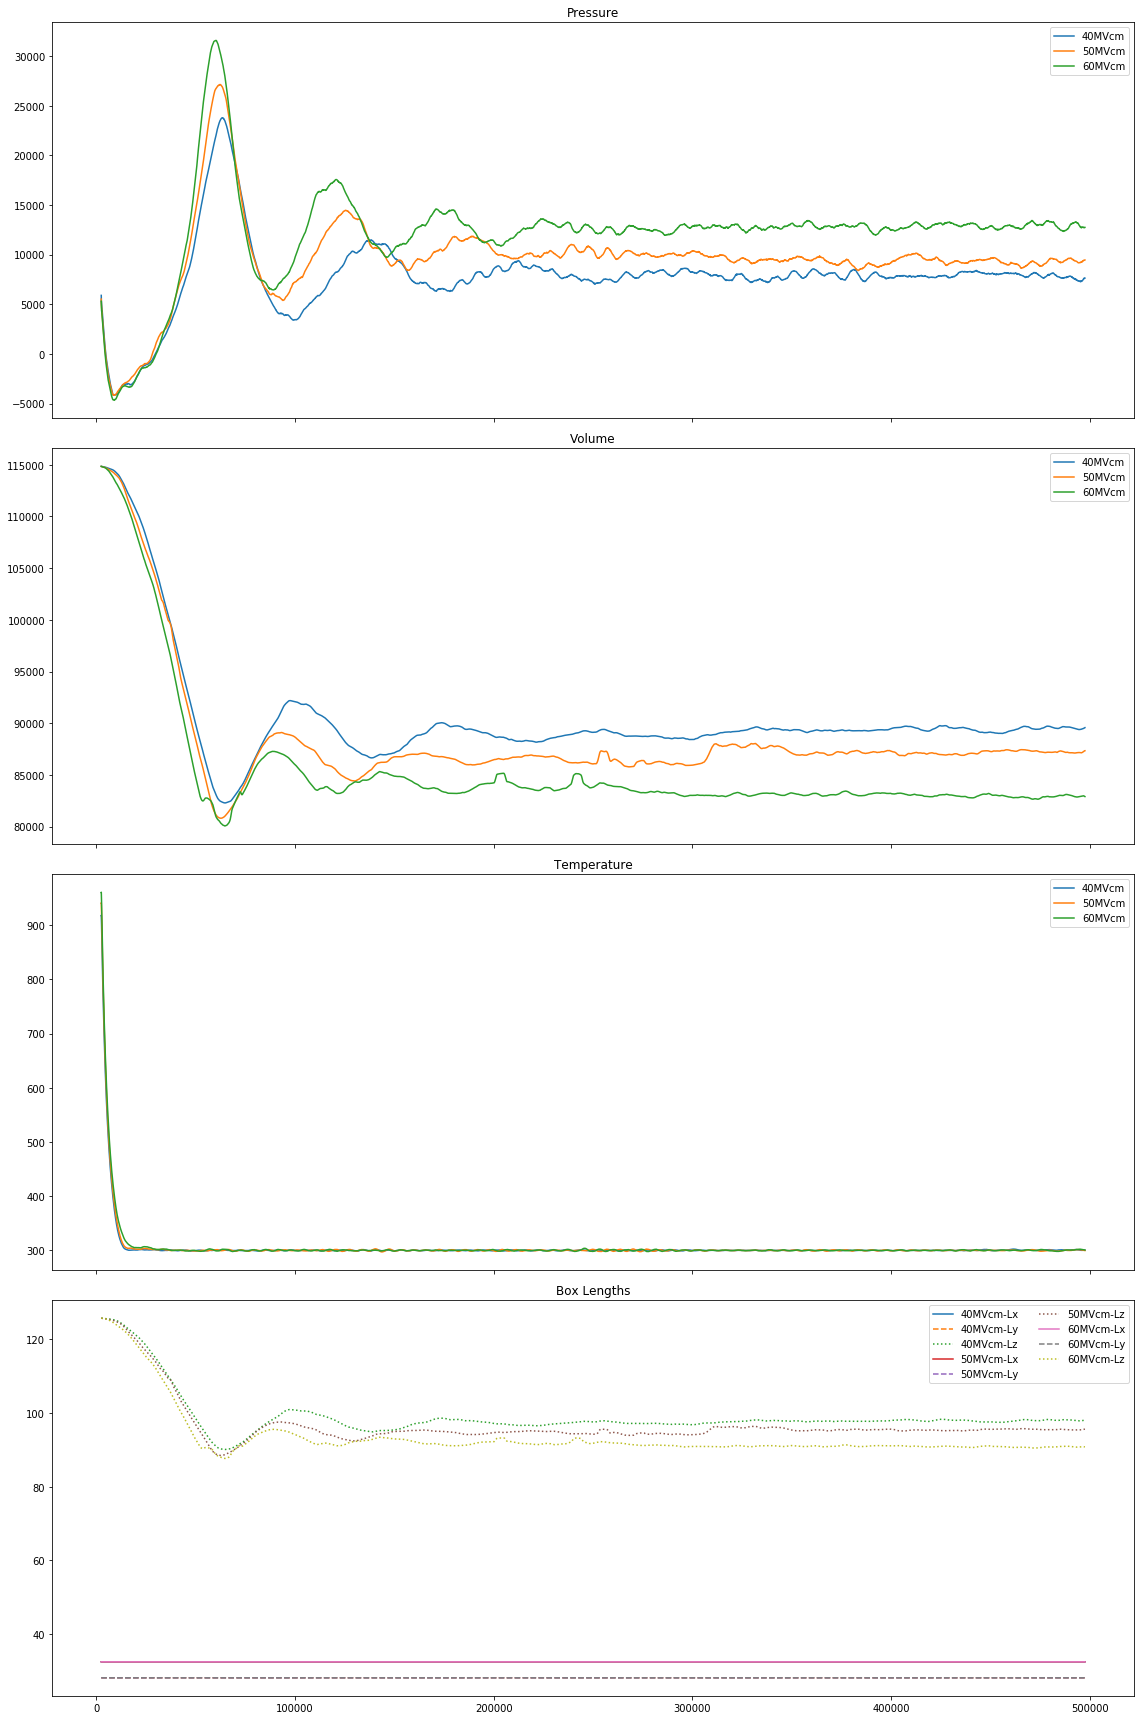

In [5]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(16, 24))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x[-6:] for x in Fe_aq_names]):
    ax1.plot(df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.temp.rolling(5000, center=True).mean(), label = name)
    
    ax4.plot(df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')
    
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=2)
f.tight_layout()
plt.show()

## Collate Prior Data

In [7]:
sim_list = {'trajectory': traj_lists,
            'log_df': log_dfs,
            'names': [x[-6:] for x in Fe_aq_names],
            'bonds_list': bonds_list,
            'connectivity_list': connectivity_list,
            'symbols': np.array(traj_lists[0][0].symbols)}

## Location of Atoms

In [433]:
# total run time = 400000
# positions_z = []
# for traj in sim_list['trajectory']:
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in range(0, len(traj), 100)]))
    
# # Savinng binary somewhere
# np.save(file='Fe_aq_co2_pos_z', arr=positions_z)
    
# Loading binary
sim_list['positions_z']=np.load('Fe_aq_co2_pos_z.npy')

### Visualization

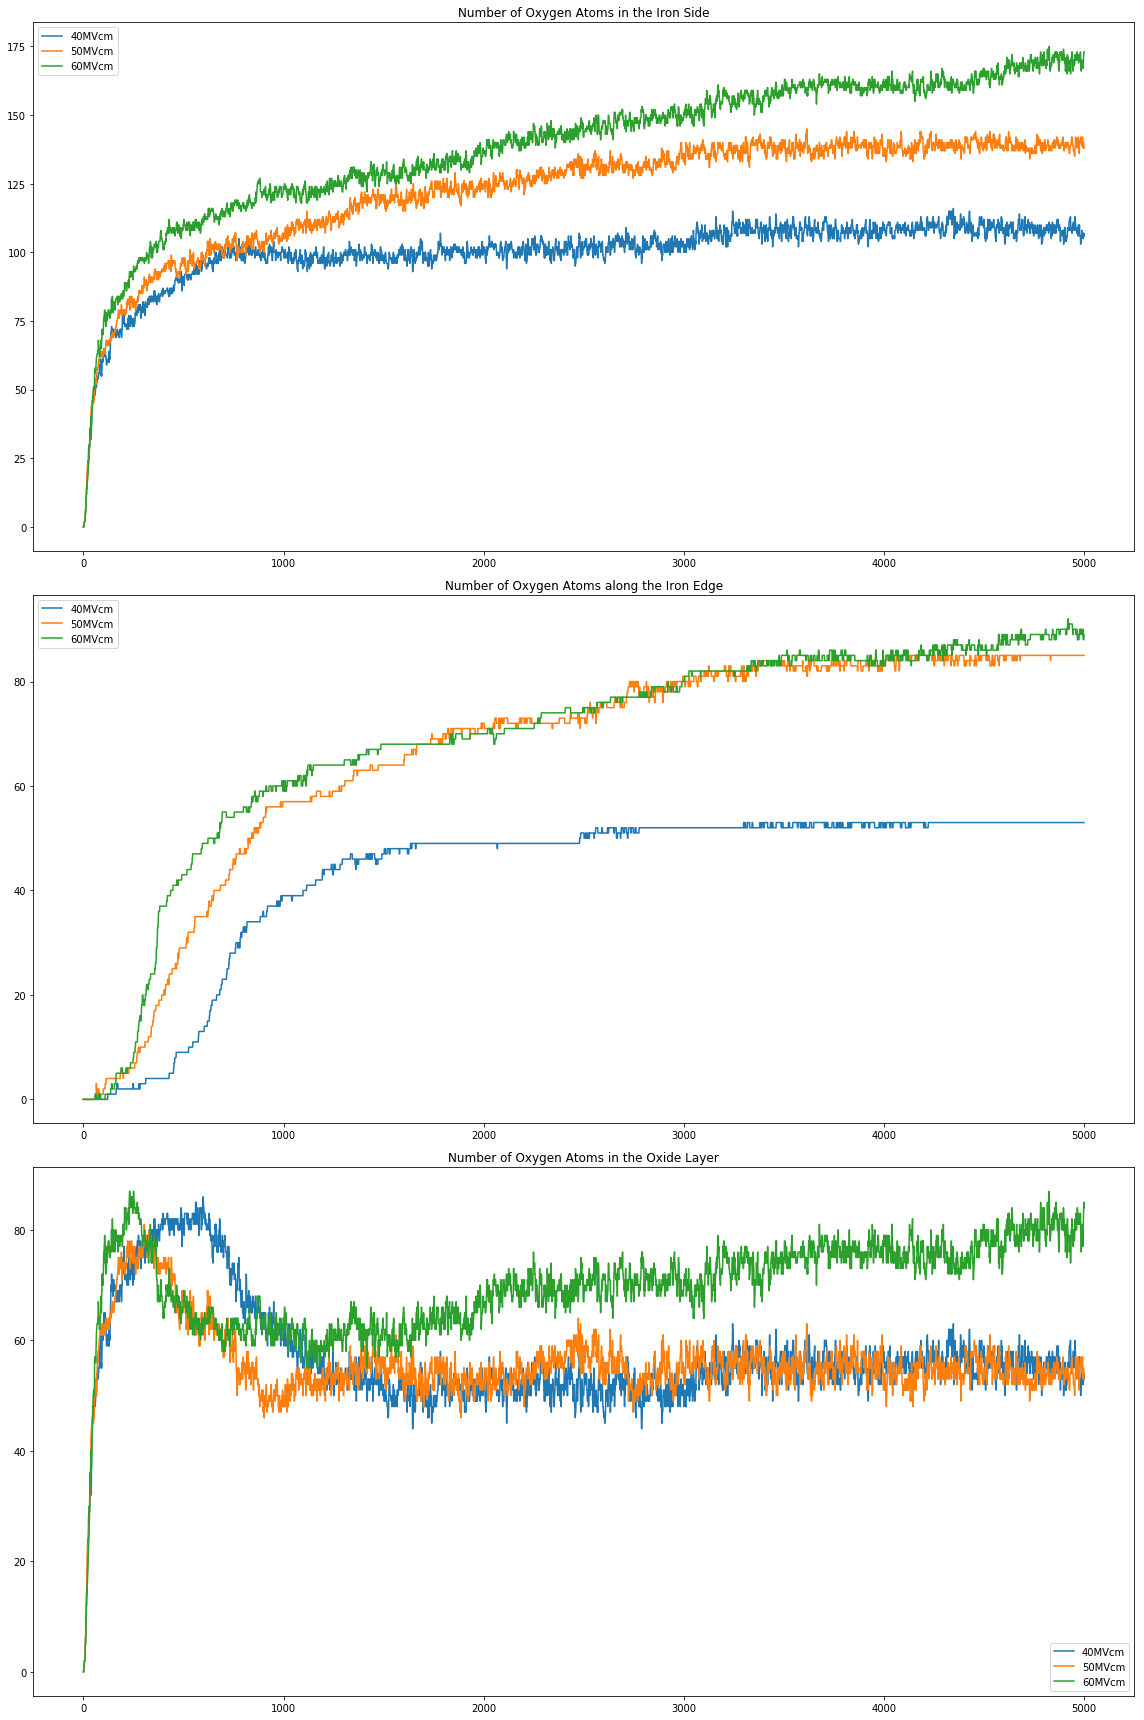

In [8]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc_upper = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], upper_cut_off, axis = 0)
    Fe_perc_lower = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], lower_cut_off, axis = 0)
    
    O_below_upper = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc_upper)])
    O_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc_lower)])
    O_middle = O_below_upper - O_below_lower
    
    ax1.plot(O_below_upper, label = name)
    ax2.plot(O_below_lower, label = name)
    ax3.plot(O_middle, label = name)

ax1.set_title("Number of Oxygen Atoms in the Iron Side")
ax2.set_title("Number of Oxygen Atoms along the Iron Edge")
ax3.set_title("Number of Oxygen Atoms in the Oxide Layer")

ax1.legend()
ax2.legend()
ax3.legend()
f.tight_layout()
plt.show()

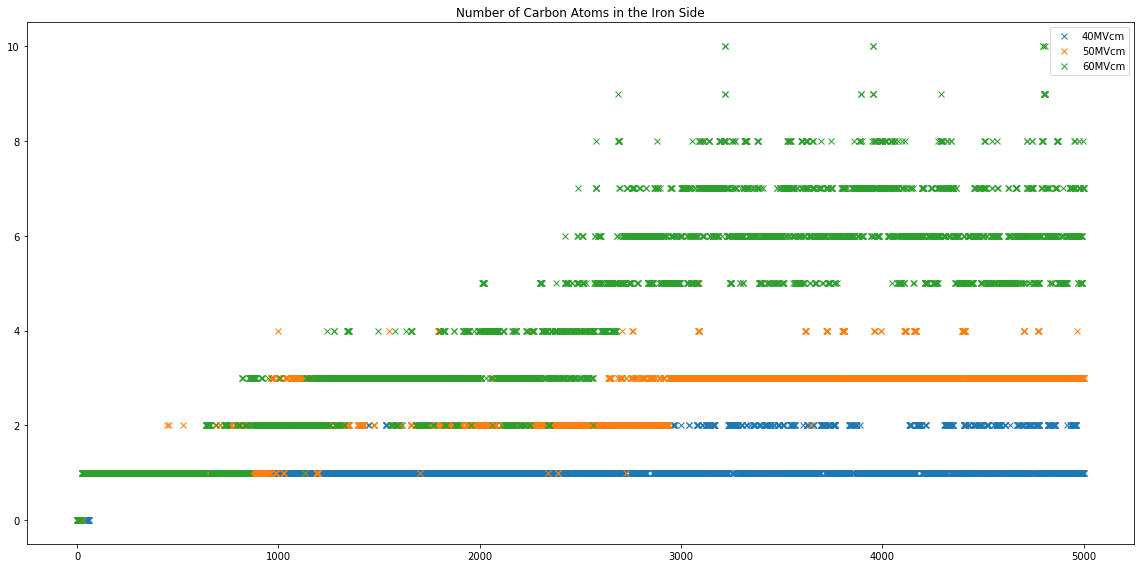

In [17]:
upper_cut_off = 97

f, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], upper_cut_off, axis = 0)
    
    C_below_upper = np.array([np.count_nonzero(i < j) for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    ax1.plot(C_below_upper, ' x', label = name)

ax1.set_title("Number of Carbon Atoms in the Iron Side")

ax1.legend()

f.tight_layout()
plt.show()

## Histogram of Distribution

### For Iron Atoms

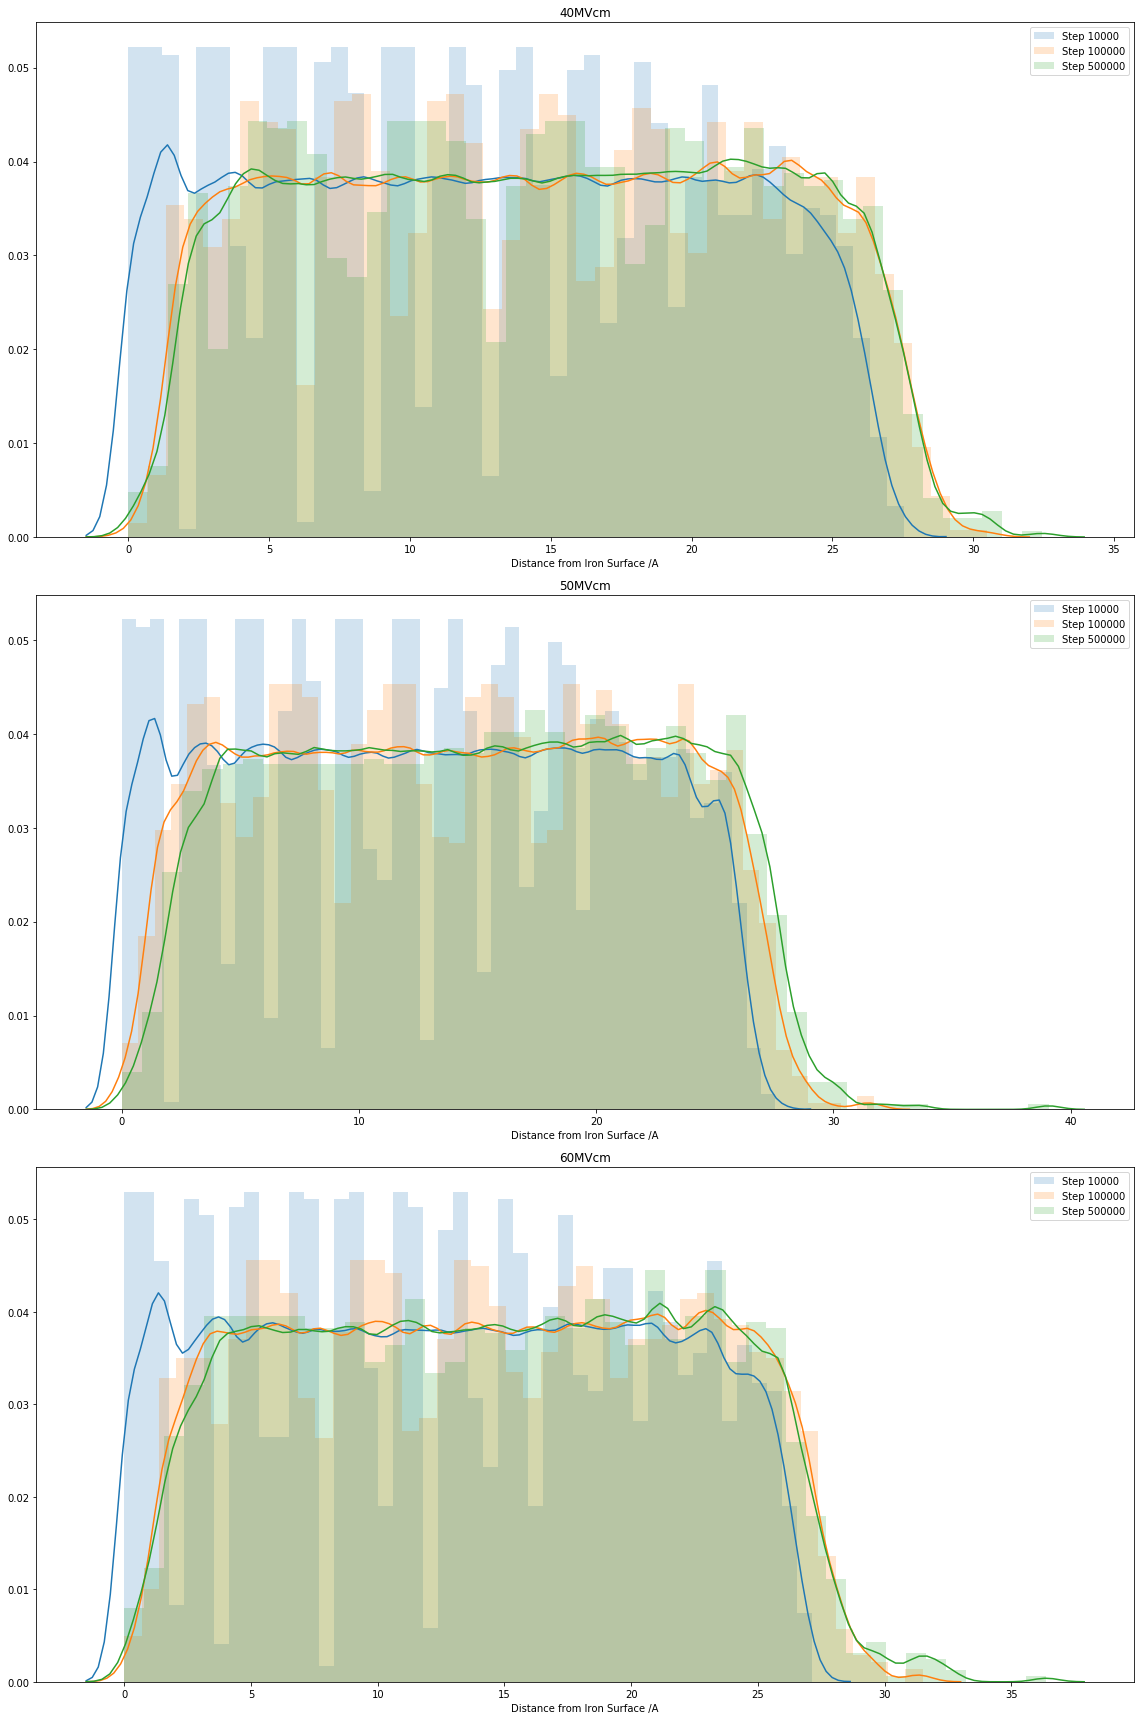

In [449]:
f, ax_arr = plt.subplots(3, 1, figsize=(16, 24))
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):

    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    
    Fe_lower = np.min(Fe_pos_z, axis = 1)
    
    Fe_delta = np.array([i-j for i, j in zip(Fe_pos_z, Fe_lower)])
    
    sns.distplot(Fe_delta[10000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 10000')
    sns.distplot(Fe_delta[100000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 100000')
    sns.distplot(Fe_delta[500000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 500000')
#     ax1.set_xlim(-35, 5)
    ax1.set_title(name)
    ax1.set_xlabel('Distance from Iron Surface /A')
    ax1.legend()
    
f.tight_layout()
plt.show()


### For Oxygen Atoms

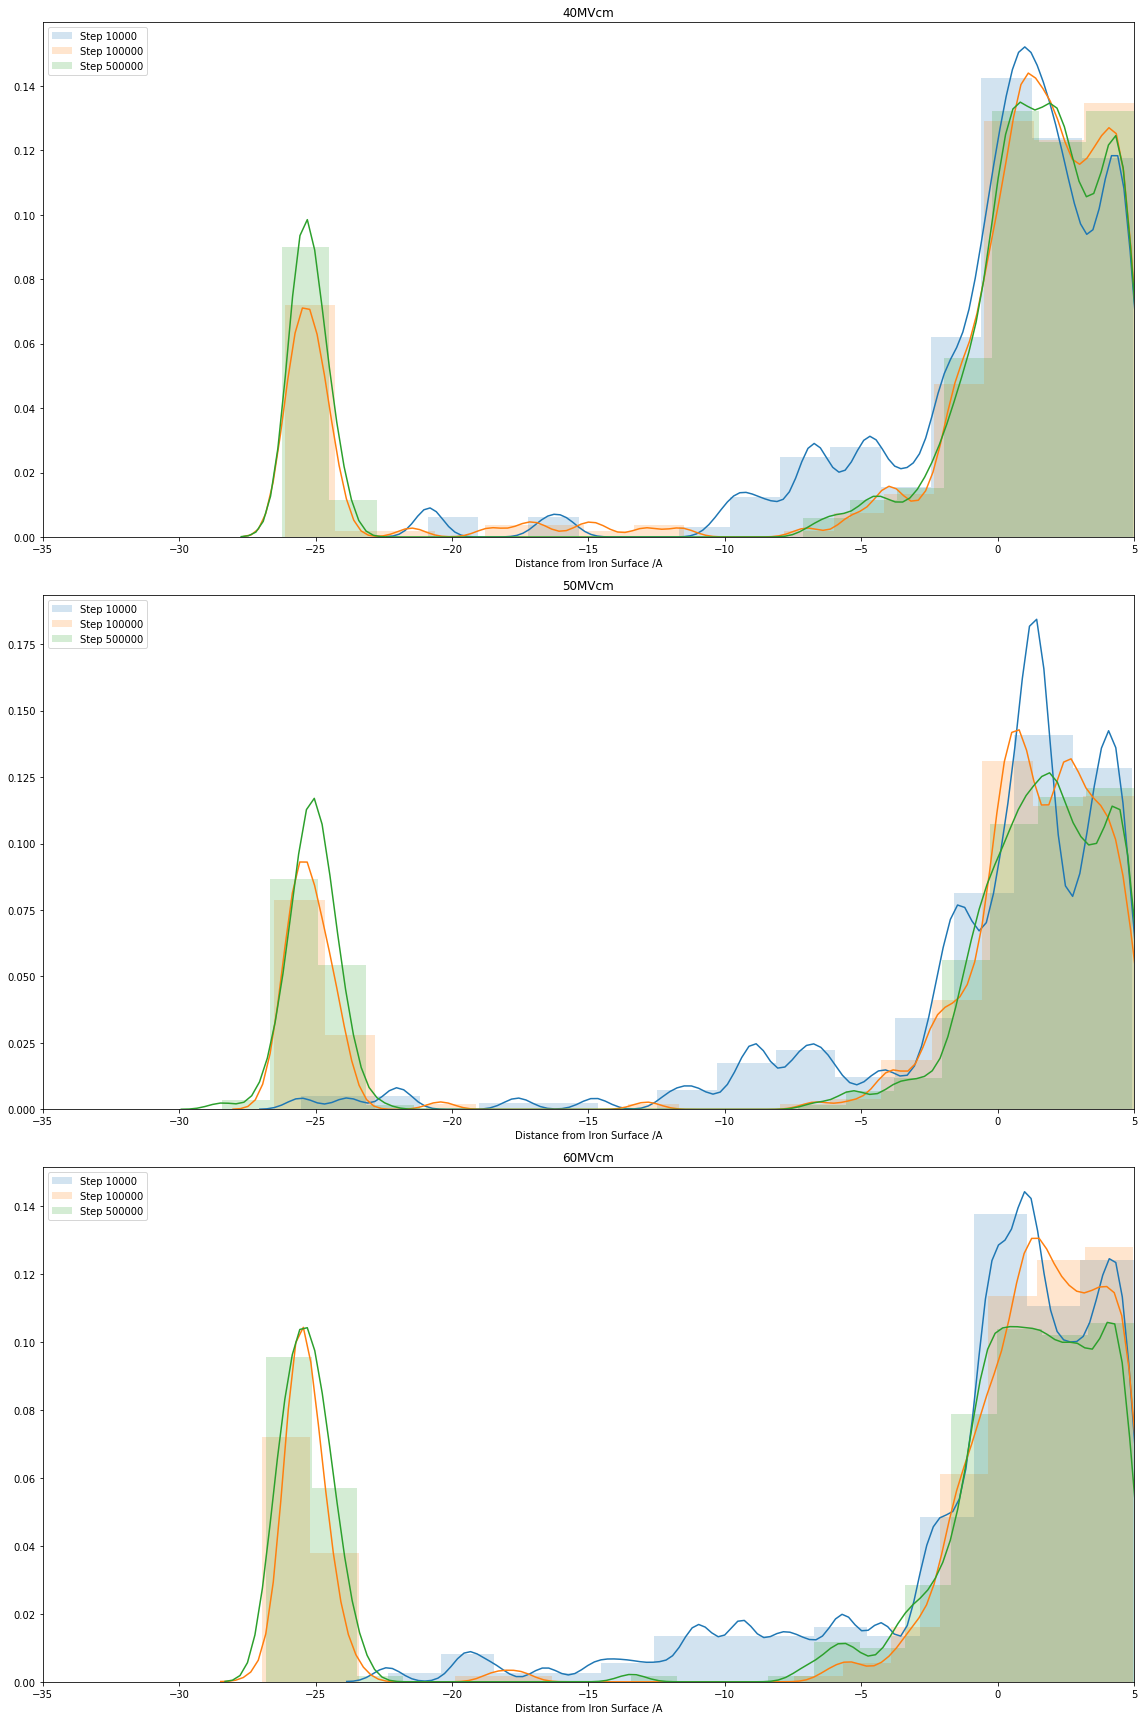

In [438]:
upper_cut_off = 97
lower_cut_off = 7

f, ax_arr = plt.subplots(3, 1, figsize=(16, 24))
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):

    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], upper_cut_off, axis = 0)
#     O_below_upper = np.array([i[i < j] for i, j in zip(O_pos_z, Fe_perc_upper)])
    
    O_delta = np.array([i[i < j+5]-j for i, j in zip(O_pos_z, Fe_perc_upper)])
    
    sns.distplot(O_delta[10000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 10000')
    sns.distplot(O_delta[100000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 100000')
    sns.distplot(O_delta[500000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 500000')
    ax1.set_xlim(-35, 5)
    ax1.set_title(name)
    ax1.set_xlabel('Distance from Iron Surface /A')
    ax1.legend()
    
f.tight_layout()
plt.show()


### For Carbon Atoms

5001
5001
5001


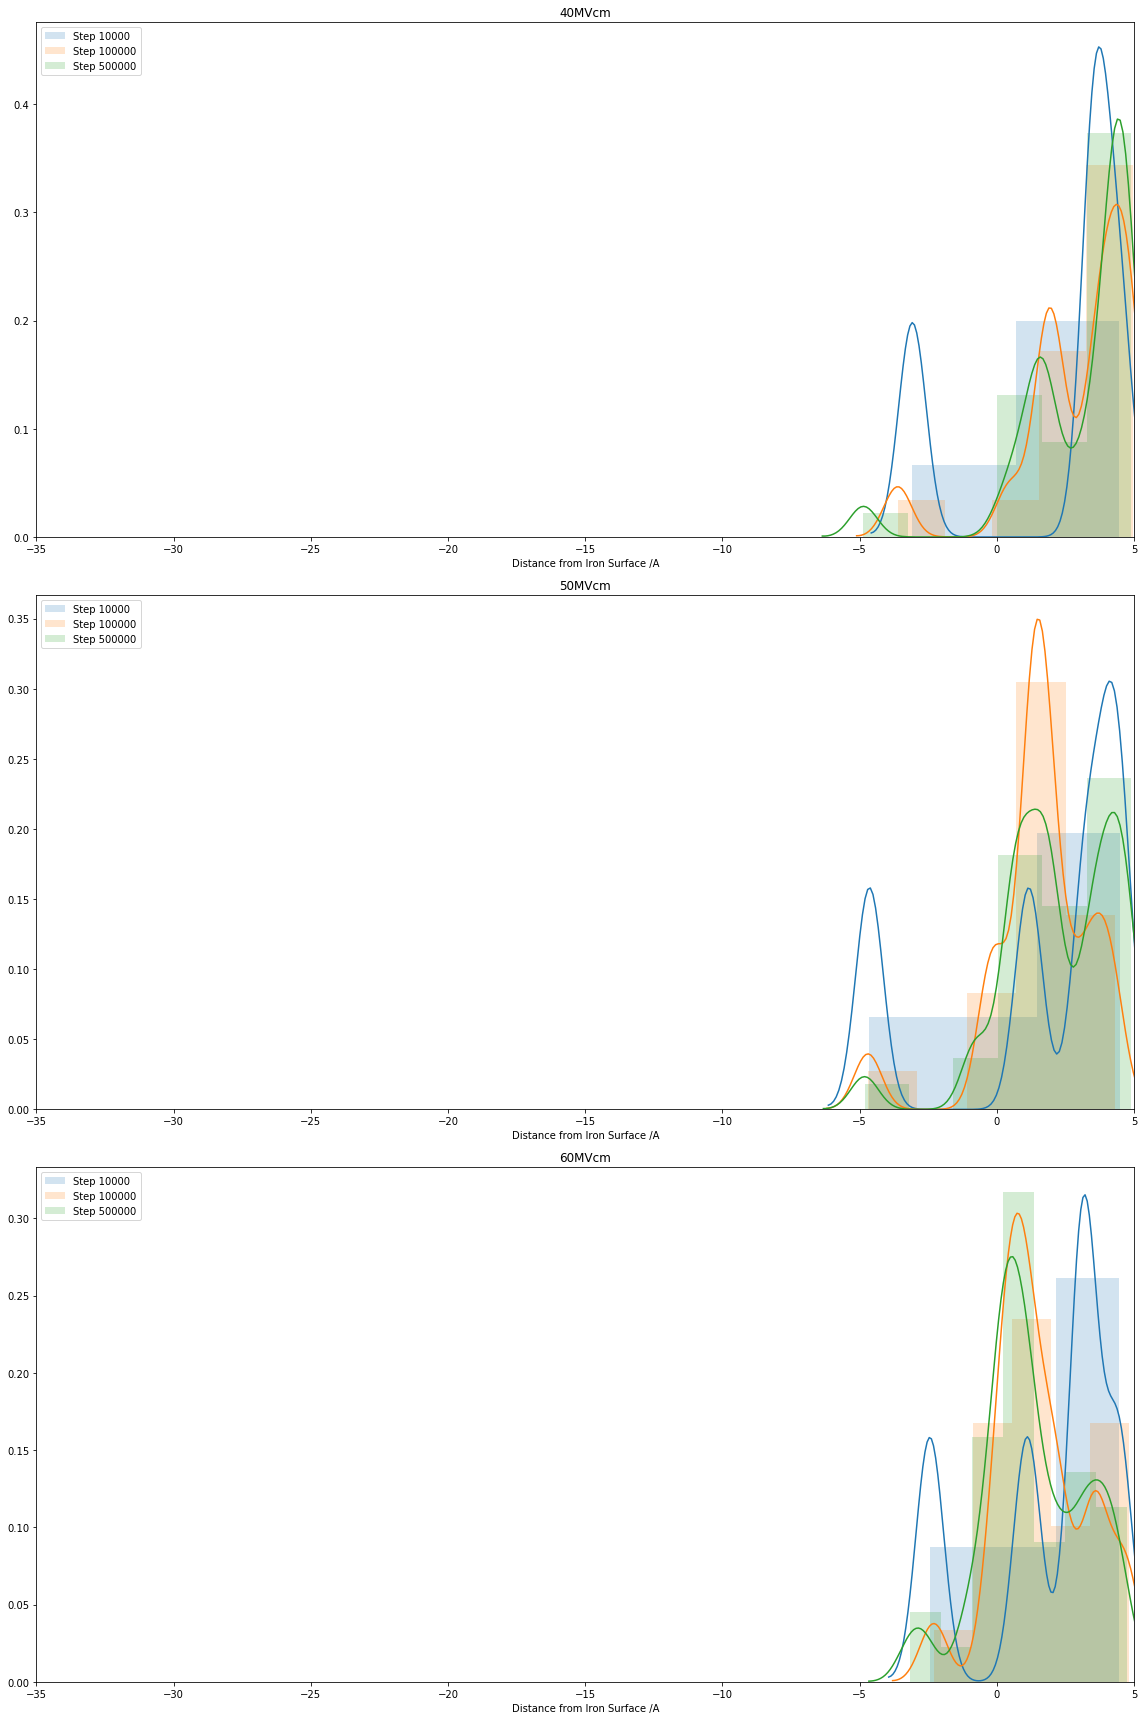

In [436]:
upper_cut_off = 97
lower_cut_off = 7

f, ax_arr = plt.subplots(3, 1, figsize=(16, 24))
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):

    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], upper_cut_off, axis = 0)
    
    C_delta = np.array([i[i < j+5]-j for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    sns.distplot(C_delta[10000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 10000')
    sns.distplot(C_delta[100000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 100000')
    sns.distplot(C_delta[500000//100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = 'Step 500000')
    ax1.set_xlim(-35, 5)
    ax1.set_title(name)
    ax1.set_xlabel('Distance from Iron Surface /A')
    ax1.legend()
    
f.tight_layout()
plt.show()


## Charge of Various Species

In [416]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=0.5))
sm.set_array([])

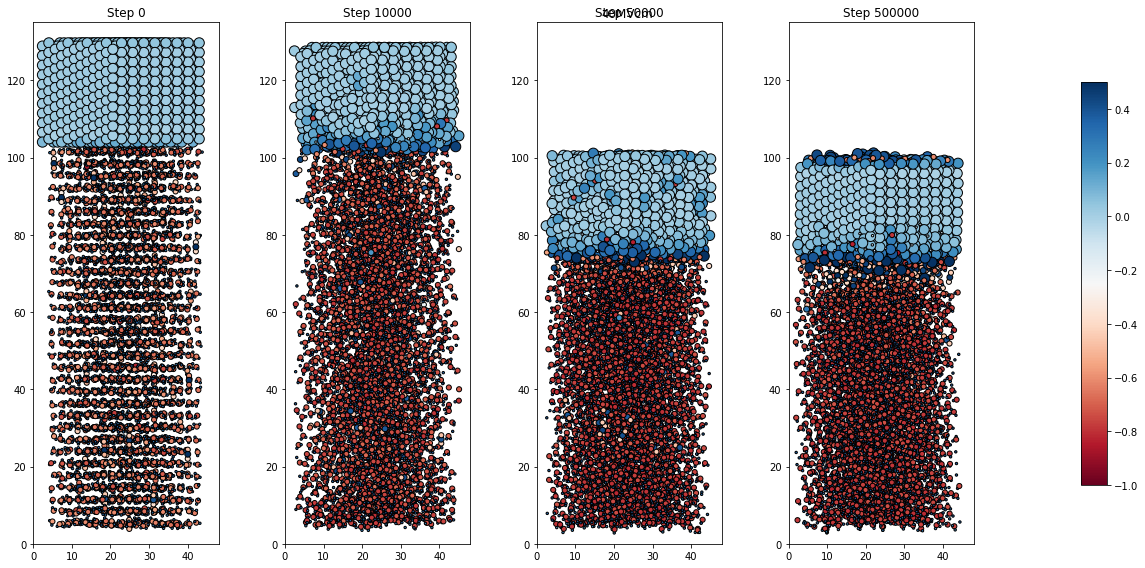

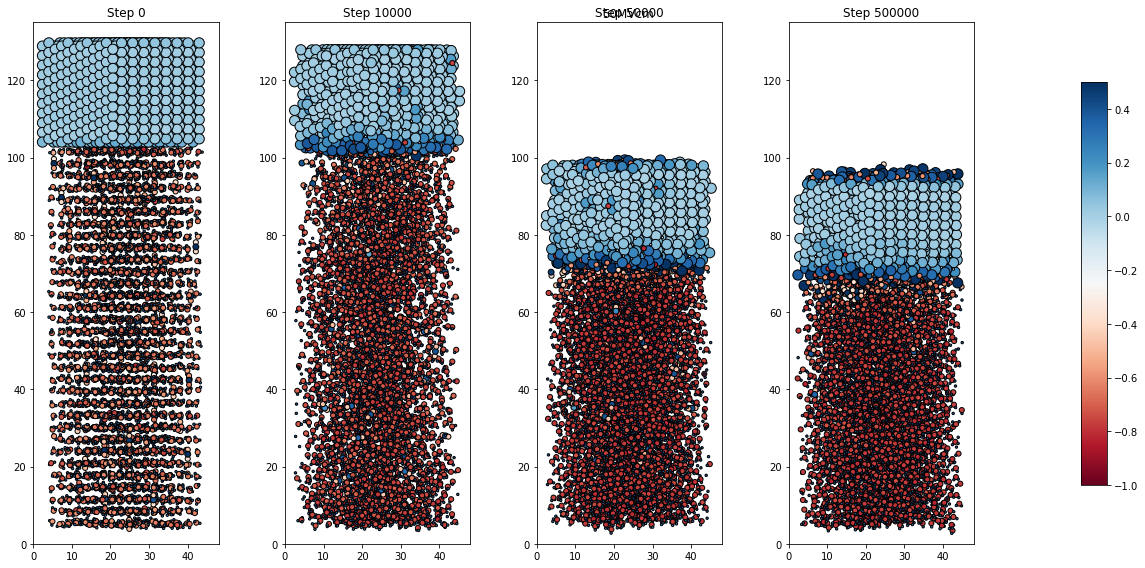

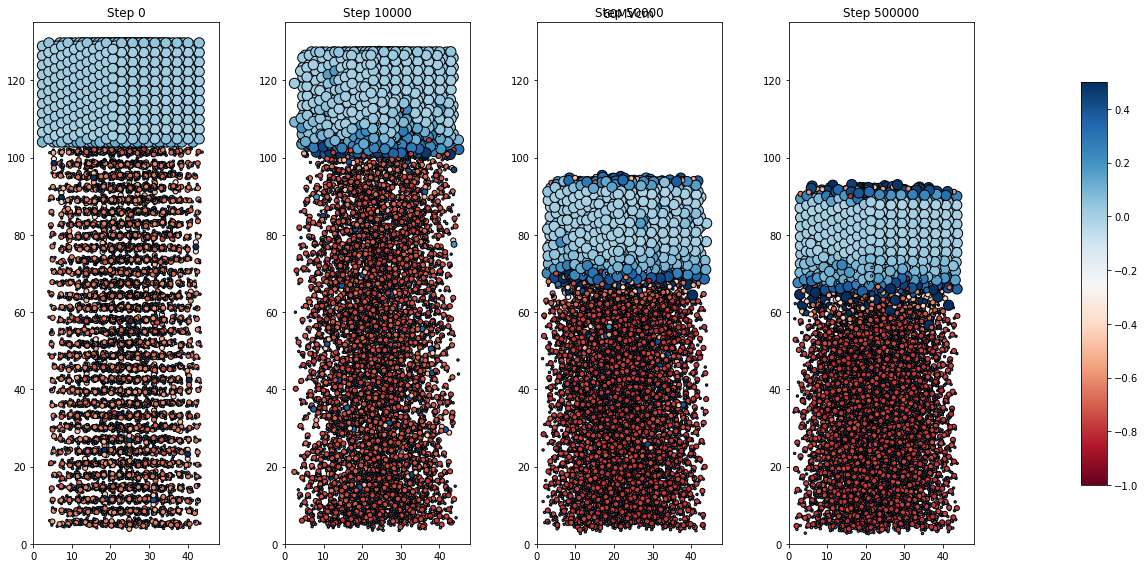

In [429]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 10000, 50000, 500000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step//10))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_xlim(0, 48)
        ax.set_ylim(0, 135)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
    
plt.show()

## Carbon Coordination

In [458]:
steps_list = np.linspace(0, 500000, 5, dtype=int)
C_index = np.argwhere(sim_list['symbols']=='C').ravel()+1

In [414]:
# Large coordinated carbon
for cl, name, traj in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:], sim_list['trajectory'][-1:]):
    print('*'*50)
    print(name)
    print('*'*50)
    
    for step, ax in zip(steps_list, ax_arr):
        print('*'*20, 'Step', step, '*'*20)
        
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step))
        primary_atoms = [[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in C_index]
        primary_atoms = [x for x in primary_atoms if len(x) > 3]
        
        secondary_atoms = [[[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in y] for y in primary_atoms]
        atoms_to_plot = [list(set([x for y in z for x in y])) for z in secondary_atoms]
        
        atoms_to_plot = [x for x in atoms_to_plot if np.any(traj[step][np.array(x)-1].get_positions()[:, 2]<35)]
        
        for atoms in atoms_to_plot:
#             f, ax = plt.subplots(figsize = (5, 5))
#             plot_atoms(traj[step][np.array(atoms)-1], ax = ax, rotation=('90x,40y,0z'))
            view(traj[step][np.array(atoms)-1])
#             ax.set_title('Step {}'.format(step))
#             plt.show()
# #         print(len(connected_atoms))
#         coordination = np.array([len(x) for x in connected_atoms])
        

**************************************************
60MVcm
**************************************************
******************** Step 0 ********************
******************** Step 12500 ********************
******************** Step 25000 ********************
******************** Step 37500 ********************
******************** Step 50000 ********************


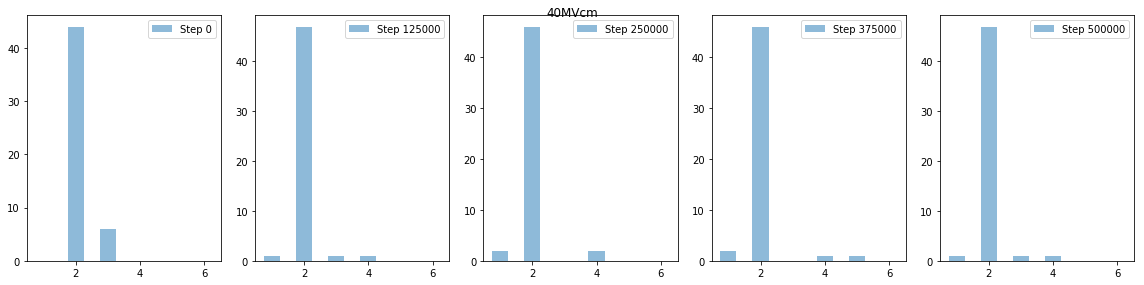

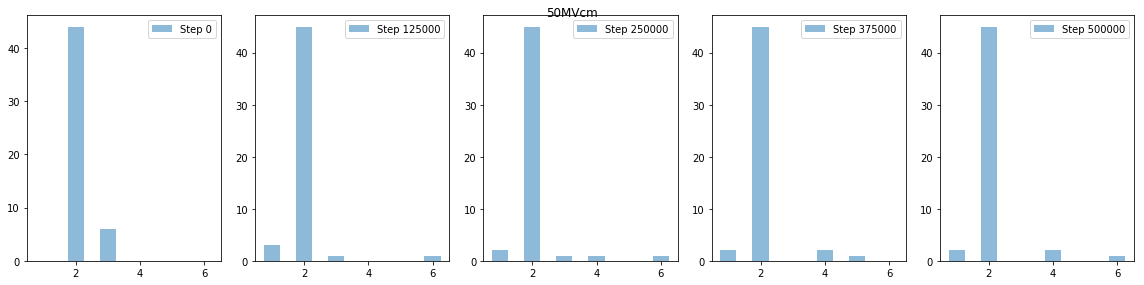

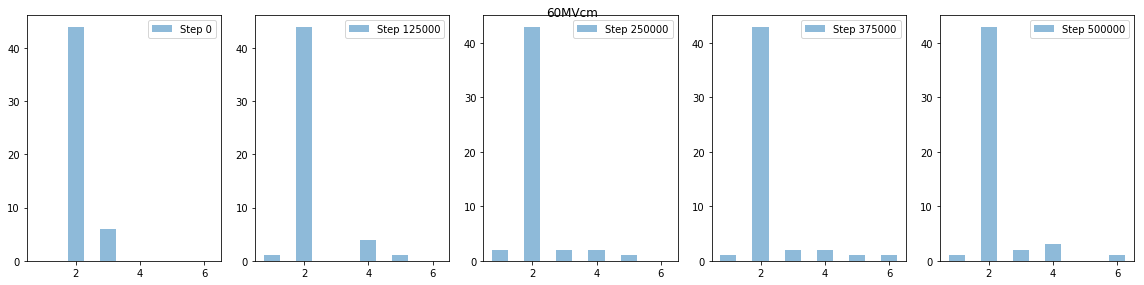

In [460]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))

    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = 'Step {}'.format(step))
        ax.legend()
        
    f.tight_layout()
    f.suptitle(name)
plt.show()

## Radial Distribution Function

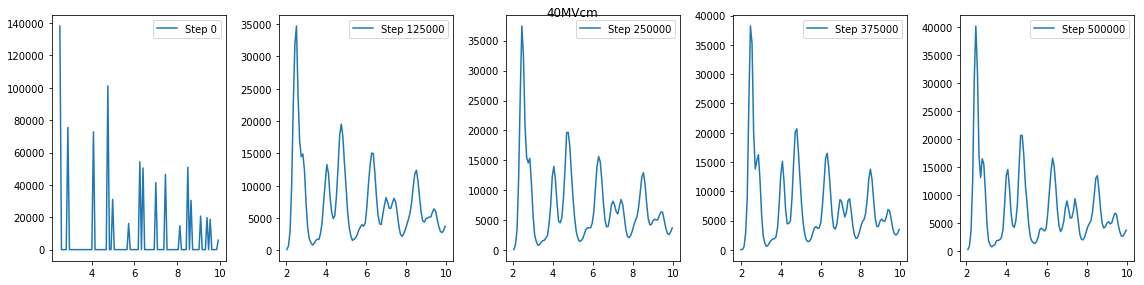

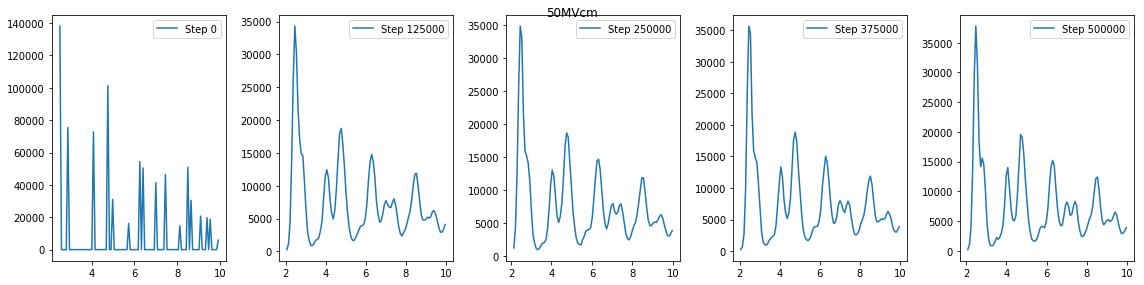

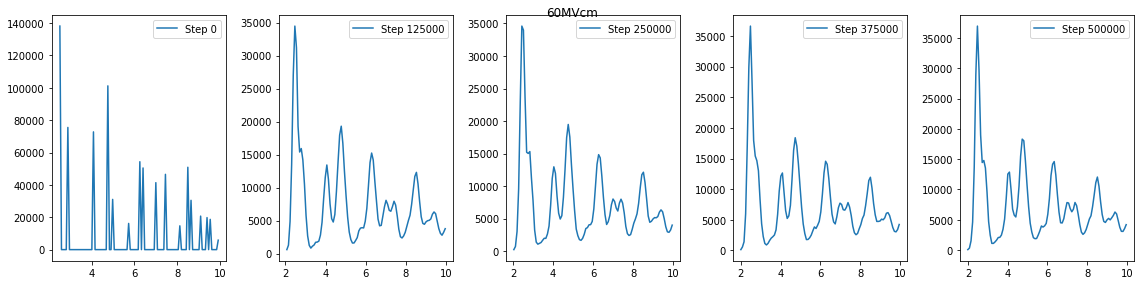

In [461]:
for traj, name in zip(sim_list['trajectory'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))
    
    for ax, step in zip(ax_arr, steps_list):
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        d = neighbor_list('d', fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=100)
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * fe_only.get_volume()/len(fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = 'Step {}'.format(step))
        ax.legend()
    f.suptitle(name)
    f.tight_layout()
    
plt.show()

## Carbon Molecules

In [273]:
def plot_connected_molecule_from_df(atom_id, step_df):
    import networkx as nx
    G = nx.from_pandas_edgelist(
        step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
    G_connected = nx.connected_components(G)
    for i in G_connected:
        if atom_id in i:
            if len(i) > 16:
                print("The atom {} connected to {} other atom is probably a bulk molecule. Not plotting.".format(atom_id, len(i)))
                break
            fig = plt.figure(figsize=(3, 3))

            sub_G = G.subgraph(i)
            edge_labels = nx.get_edge_attributes(sub_G, 'bond_order')
            node_labels = dict(
                zip(i, sim_list['symbols'][np.array(list(i))-1]))
            colors = [CPK_COLORING[v] for k, v in node_labels.items()]

            pos = nx.spring_layout(sub_G)

            nx.draw(sub_G, pos, node_color=colors)
            nx.draw_networkx_labels(sub_G, pos,  node_labels)
    #         nx.draw_networkx_edge_labels(sub_G, pos, edge_labels)
            fig.set_facecolor("#c9c9c9")

D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'H']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 10578 connected to 2697 other atom is probably a bulk molecule. Not plotting.
['O' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10578 connected to 2725 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10578 connected to 2750 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'O' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10578 connected to 2755 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'H']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 10578 connected to 2694 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 10578 connected to 2744 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10578 connected to 2785 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10578 connected to 2793 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'H']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10551 connected to 2737 other atom is probably a bulk molecule. Not plotting.
['O' 'O' 'O' 'Fe']
The atom 10578 connected to 2737 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 10551 connected to 2818 other atom is probably a bulk molecule. Not plotting.
['O' 'O' 'O']
The atom 10578 connected to 2818 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 10551 connected to 2878 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'O' 'O']
The atom 10569 connected to 2878 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']
The atom 10578 connected to 2878 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 10551 connected to 2905 other atom is probably a bulk molecule. Not plotting.
['O' 'O' 'O']
The atom 10569 connected to 2905 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']
The atom 10578 connected to 2905 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


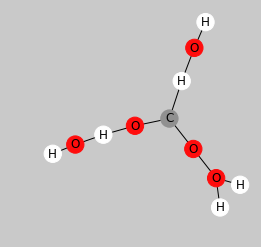

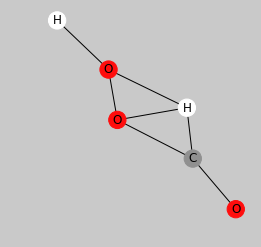

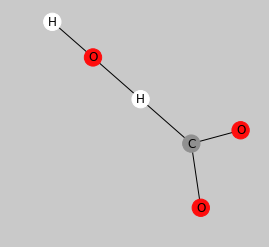

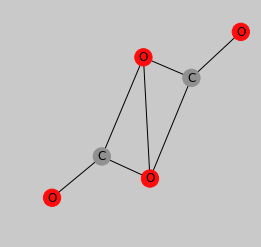

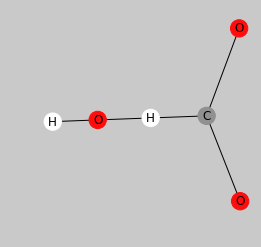

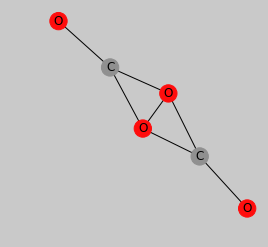

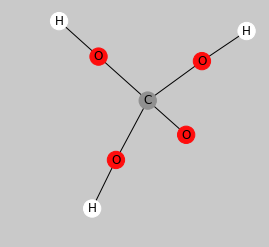

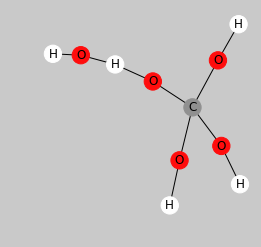

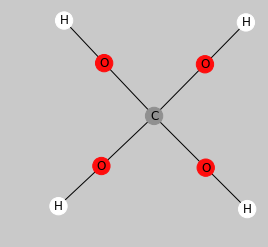

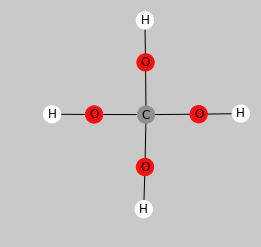

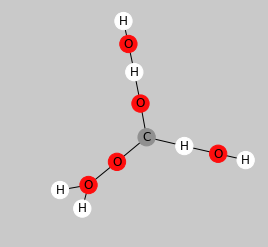

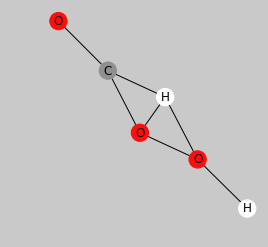

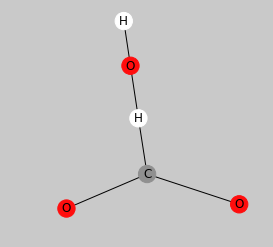

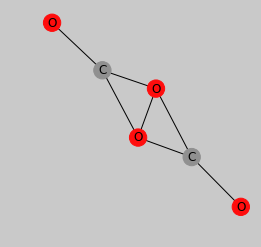

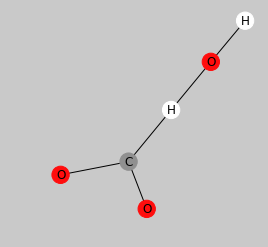

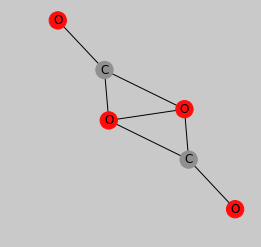

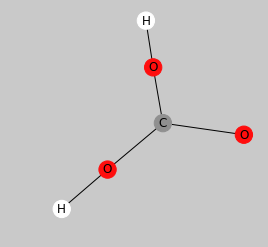

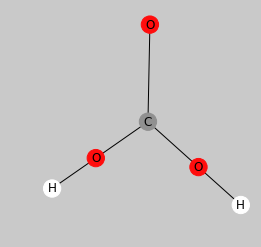

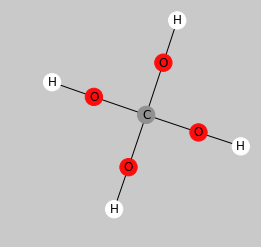

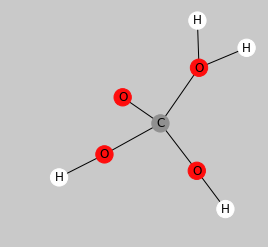

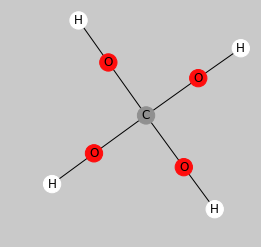

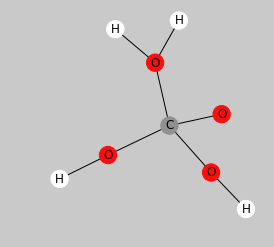

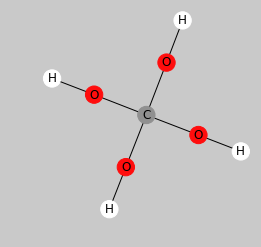

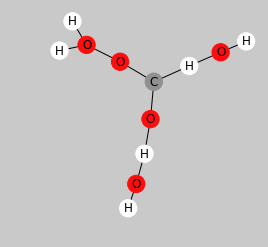

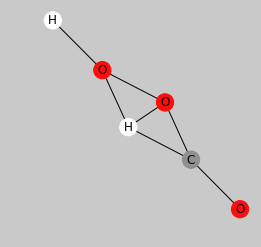

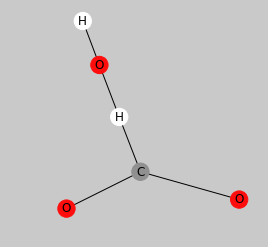

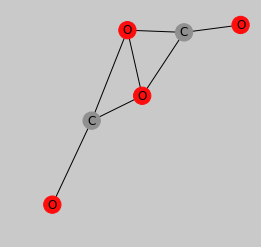

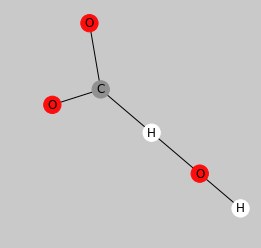

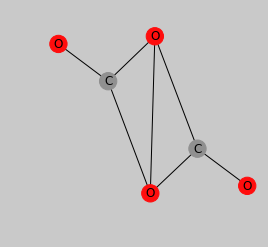

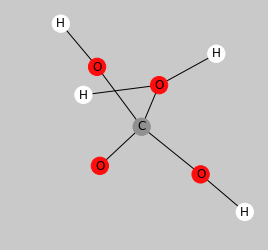

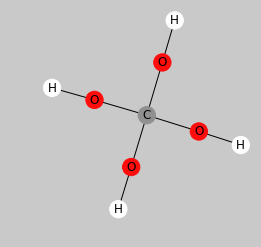

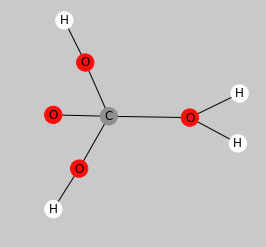

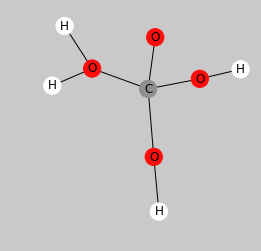

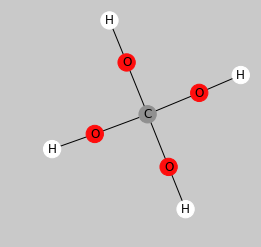

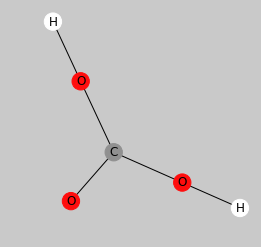

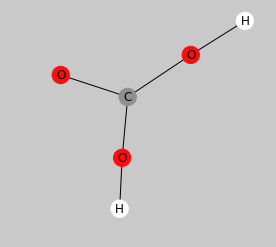

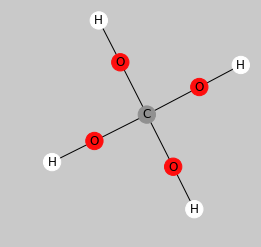

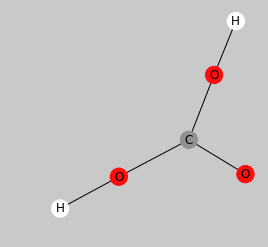

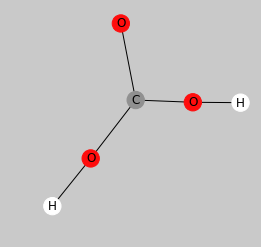

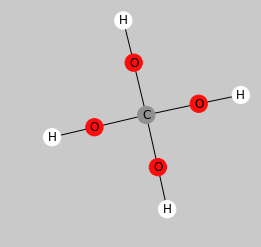

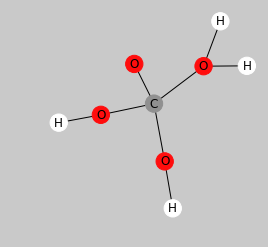

In [463]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        for i in C_index[coordination>2]:
            plot_connected_molecule_from_df(i, step_df)
            conn_df = step_df[step_df.atom_a == i]
            print(sim_list['symbols'][conn_df.atom_b-1])

## Backup Animation Production and Saving

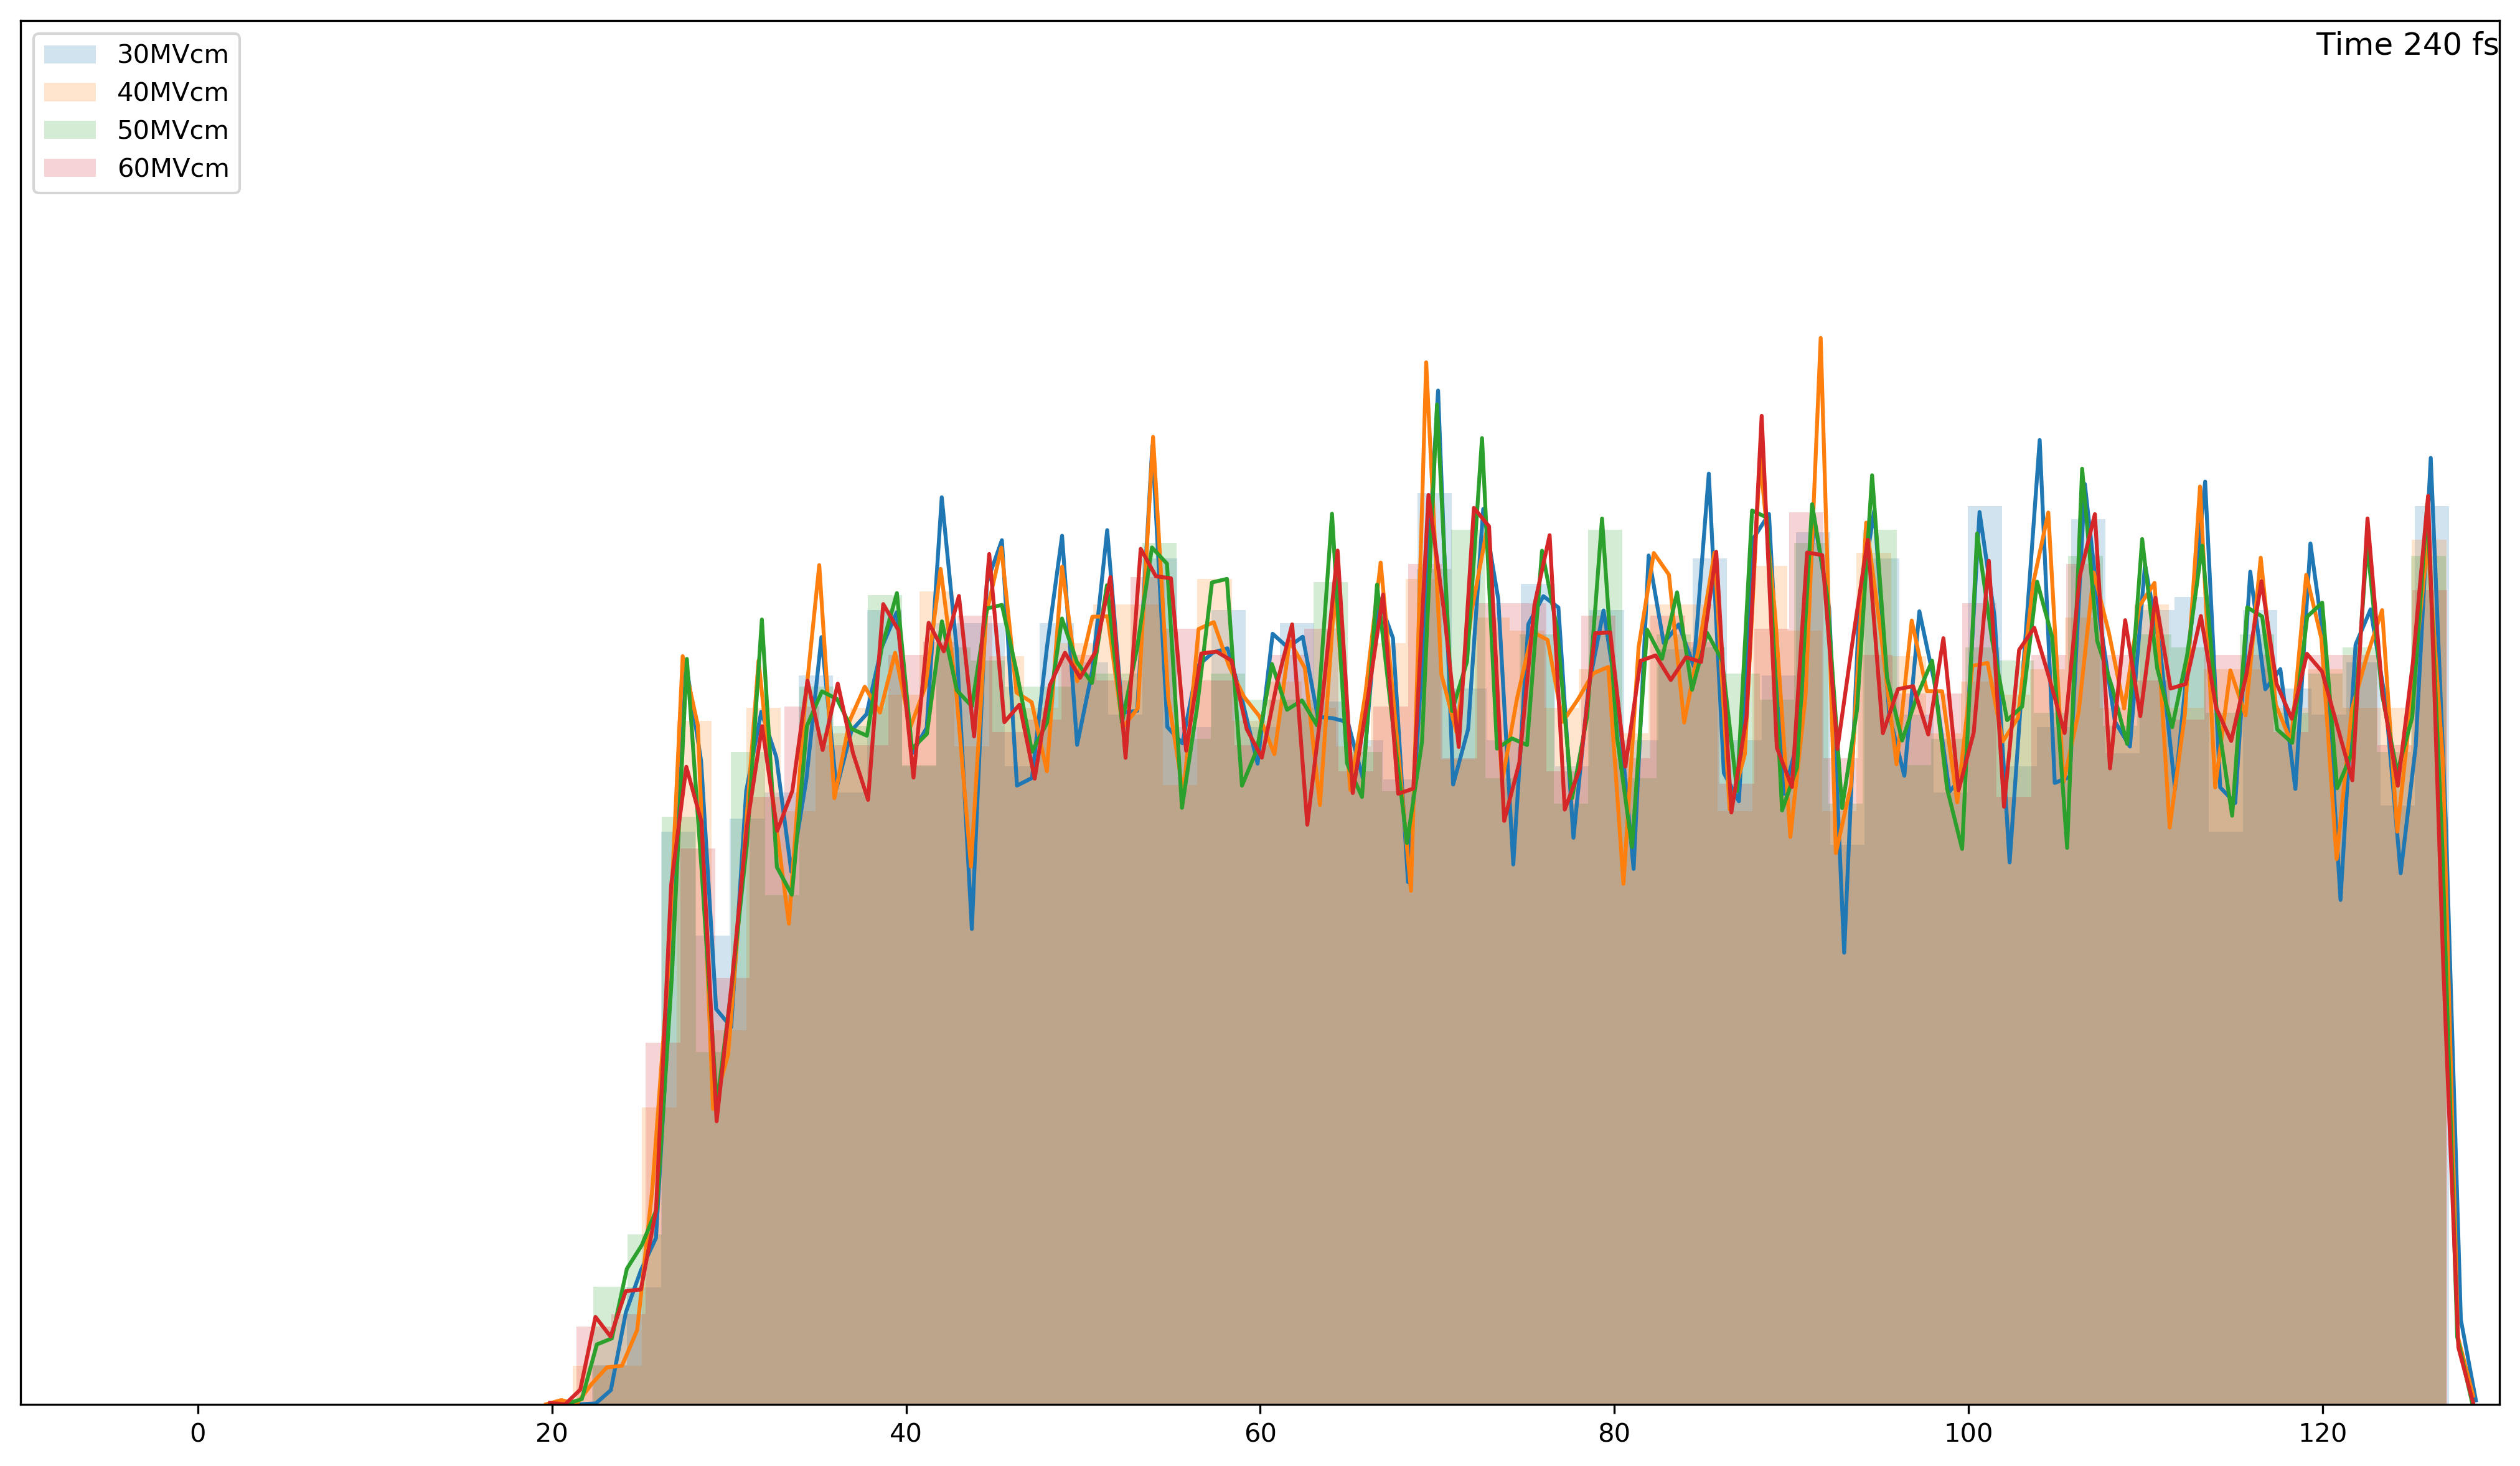

In [125]:
import subprocess

def testSubprocess(outf='testSubprocess.mp4', nframes=1):

    #set up the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    fig.set_dpi(300)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    
    # First frame
    ax.tick_params(labelleft=False, left=False)
    sns.kdeplot([], ax = ax)
    ax.set_xlim(-10, 130)
    ax.set_ylim(0, 0.019)

    def update(num):
            ax.clear()
            sns.distplot(sim_list['O_pos_z'][0][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][0])
            sns.distplot(sim_list['O_pos_z'][1][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][1])
            sns.distplot(sim_list['O_pos_z'][2][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][2])
            sns.distplot(sim_list['O_pos_z'][3][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][3])
            ax.set_title('Time {} fs'.format(num*10), loc='right', pad=-13)
            ax.set_xlim(-10, 130)
            ax.set_ylim(0, 0.019)
            ax.legend(loc=2)

    # Open an ffmpeg process
    cmdstring = ('/local/yiming/miniconda3/bin/ffmpeg', 
                 '-y', '-r', '25', # overwrite
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-crf', '20',
                 '-vcodec', 'libx264', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

testSubprocess(outf='Fe_H2O_efield.mp4', nframes=len(sim_list['O_pos_z'][0]))

## backup nx graphing